<a href="https://colab.research.google.com/github/MDIL-SNU/SevenNet/blob/tutorial/tutorial/SevenNet_python_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SevenNet tutorial: python interactive
---
This notebook is a python interactive tutorial for SevenNet.\
[paper](https://pubs.acs.org/doi/10.1021/acs.jctc.4c00190)\
[code](https://github.com/MDIL-SNU/SevenNet) \
We recommend using a GPU. If you're using Colab, go to:\
[Runtime] -> [Change runtime type] -> [T4 GPU] -> [Save]

If you're using Colab, it may crash occasionally. If it does, try starting from the beginning or from the cell where it crashed. If that doesn’t work, go to: \
[Runtime] -> [Disconnect and delete runtime] -> restart!

## 0. Installation
First of all, let's install SevenNet to our computer!

In [1]:
# Install SevenNet
!pip install sevenn

# If you want to check the SevenNet code, clone the repo.
# !git clone https://github.com/MDIL-SNU/SevenNet.git

# libraries for visualization
!pip install pymatgen
!pip install py3Dmol

import os
working_dir = os.getcwd() # save current path

In [2]:
# check if sevenn is installed well
import sevenn
sevenn.__version__

'0.10.1'

## 1. Dataset

In [3]:
# download the dataset
!git clone https://github.com/MDIL-SNU/sevennet_tutorial.git


fatal: destination path 'sevennet_tutorial' already exists and is not an empty directory.


## 2. Training from scratch

### Dataset setting

In [4]:
from sevenn.train.graph_dataset import SevenNetGraphDataset

dataset_prefix = './sevennet_tutorial/data/train/'
xyz_files = ['1200K.extxyz', '600K.extxyz']
dataset_files = [os.path.join(dataset_prefix, xyz) for xyz in xyz_files]

# Preprocess(build graphs) data before training. It will automatically saves processed graph to {root}/sevenn_data/train.pt, metadata + statistics as train.yaml
dataset = SevenNetGraphDataset(cutoff=5.0, root=working_dir, files=dataset_files, processed_name='train.pt')

print(f'# graphs: {len(dataset)}')
print(f'# atoms (nodes): {dataset.natoms}')
print(dataset[0])

# graphs: 170
# atoms (nodes): {'Cl': 5440, 'Li': 32640, 'P': 5440, 'S': 27200, 'total': 70720}
AtomGraphData(
  x=[416],
  edge_index=[2, 11254],
  pos=[416, 3],
  node_attr=[416],
  atomic_numbers=[416],
  edge_vec=[11254, 3],
  total_energy=[1],
  force_of_atoms=[416, 3],
  stress=[1, 6],
  cell_lattice_vectors=[3, 3],
  pbc_shift=[11254, 3],
  cell_volume=[1],
  num_atoms=[1],
  per_atom_energy=[1],
  data_info={}
)


/home/hexagonrose/miniconda3/envs/seven/lib/python3.9/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([AtomGraphData])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


In [5]:
from torch_geometric.loader import DataLoader

# split the dataset into train & valid
num_dataset = len(dataset)
num_train = int(num_dataset * 0.95)
num_valid = num_dataset - num_train

dataset = dataset.shuffle()
train_dataset = dataset[:num_train]
valid_dataset = dataset[num_train:]

print(f'# graphs for training: {len(train_dataset)}')
print(f'# graphs for validation: {len(valid_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

# graphs for training: 161
# graphs for validation: 9


### Model setting

In [6]:
from copy import deepcopy

from sevenn._const import DEFAULT_E3_EQUIVARIANT_MODEL_CONFIG
from sevenn.model_build import build_E3_equivariant_model
import sevenn.util as util

train_shift = dataset.per_atom_energy_std
train_scale = dataset.force_rms
train_conv_denominator = dataset.avg_num_neigh

# copy default model configuration.
model_cfg = deepcopy(DEFAULT_E3_EQUIVARIANT_MODEL_CONFIG)

# tune the channel and lmax parameters. You can experiment with different settings.
model_cfg.update({'channel': 16, 'lmax': 2})

# tell models about element in universe
model_cfg.update(util.chemical_species_preprocess([], universal=True))

# tell model about statistics of dataset. kind of data standardization
model_cfg.update({'shift': train_shift, 'scale': train_scale, 'conv_denominator': train_conv_denominator})

model = build_E3_equivariant_model(model_cfg)
num_weights = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model) # model info
print(f'# model weights: {num_weights}')

AtomGraphSequential(
  (edge_embedding): EdgeEmbedding(
    (basis_function): BesselBasis()
    (cutoff_function): PolynomialCutoff()
    (spherical): SphericalEncoding(
      (sph): SphericalHarmonics()
    )
  )
  (onehot_idx_to_onehot): OnehotEmbedding()
  (onehot_to_feature_x): IrrepsLinear(
    (linear): Linear(119x0e -> 16x0e | 1904 weights)
  )
  (0_self_connection_intro): SelfConnectionIntro(
    (fc_tensor_product): FullyConnectedTensorProduct(16x0e x 119x0e -> 48x0e+16x1o+16x2e | 91392 paths | 91392 weights)
  )
  (0_self_interaction_1): IrrepsLinear(
    (linear): Linear(16x0e -> 16x0e | 256 weights)
  )
  (0_convolution): IrrepsConvolution(
    (convolution): TensorProduct(16x0e x 1x0e+1x1o+1x2e -> 16x0e+16x1o+16x2e | 48 paths | 48 weights)
    (weight_nn): FullyConnectedNet[8, 64, 64, 48]
  )
  (0_self_interaction_2): IrrepsLinear(
    (linear): Linear(16x0e+16x1o+16x2e -> 48x0e+16x1o+16x2e | 1280 weights)
  )
  (0_self_connection_outro): SelfConnectionOutro()
  (0_equivar

### Start training
If you want more accurate model, increase the num_epoch!

In [7]:
from sevenn._const import DEFAULT_TRAINING_CONFIG
from sevenn.train.trainer import Trainer

# copy default training configuration
train_cfg = deepcopy(DEFAULT_TRAINING_CONFIG)

# set optimizer and scheduler for training.
train_cfg.update({
  'device': 'cuda',
  'optimizer': 'adam',
  'optim_param': {'lr': 0.01},
  'scheduler': 'linearlr',
  'scheduler_param': {'start_factor': 1.0, 'total_iters': 100, 'end_factor': 0.0001},
})

# Initialize trainer. It implements common rountines for training.
trainer = Trainer.from_config(model, train_cfg)
print(trainer.loss_functions)  # We have energy, force, stress loss function by defaults. With default 1.0, 0.1, and 1e-6 loss weight
print(trainer.optimizer)
print(trainer.scheduler)

[(Energy, 1.0), (Force, 0.1), (Stress, 1e-06)]
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [8]:
from sevenn.error_recorder import ErrorRecorder

train_cfg.update({
  # List of tuple [Quantity name, metric name]
  # Supporting quantities: Energy, Force, Stress, Stress_GPa
  # Supporting metrics: RMSE, MAE, Loss
  # TotalLoss is special!
  'error_record': [
    ('Energy', 'RMSE'),
    ('Force', 'RMSE'),
    # ('Stress', 'RMSE'),  We skip stress error cause it is too long to print, uncomment it if you want
    ('TotalLoss', 'None'),
  ]
})
train_recorder = ErrorRecorder.from_config(train_cfg)
valid_recorder = deepcopy(train_recorder)
for metric in train_recorder.metrics:
  print(metric)

Energy_RMSE (eV/atom): nan
Force_RMSE (eV/Å): nan
TotalLoss: nan


In [9]:
from tqdm import tqdm

valid_best = float('inf')
total_epoch = 60
pbar = tqdm(range(total_epoch))
config = model_cfg  # to save config used in this tutorial.
config.update(train_cfg)

for epoch in pbar:
  # trainer scans whole data from given loader, and updates error recorder with outputs.
  trainer.run_one_epoch(train_loader, is_train=True, error_recorder=train_recorder)
  trainer.run_one_epoch(valid_loader, is_train=False, error_recorder=valid_recorder)
  train_err = train_recorder.epoch_forward()  # return averaged error over one epoch, then reset.
  valid_err = valid_recorder.epoch_forward()

  # for print. train_err is a dictionary of {metric name with unit: error}
  err_str = 'Train: ' + '    '.join([f'{k}: {v:.3f}' for k, v in train_err.items()])
  err_str += '// Valid: ' + '    '.join([f'{k}: {v:.3f}' for k, v in valid_err.items()])
  pbar.set_description(err_str)

  if valid_err['TotalLoss'] < valid_best:  # saves best checkpoint. by comparing validation set total loss
    valid_best = valid_err['TotalLoss']
    trainer.write_checkpoint(os.path.join(working_dir, 'checkpoint_best.pth'), config=config, epoch=epoch)

Train: Energy_RMSE (eV/atom): 0.010    Force_RMSE (eV/Å): 0.335    TotalLoss: 0.004// Valid: Energy_RMSE (eV/atom): 0.006    Force_RMSE (eV/Å): 0.318    TotalLoss: 0.003: 100%|██████████| 60/60 [06:53<00:00,  6.89s/it] 


## 3. Model test
### Energy / force plot
Let's predict the energy and force of training/test dataset and draw the parity plots

In [10]:
# load test model
import torch
import ase.io

from sevenn.sevennet_calculator import SevenNetCalculator

# Let's test our model by predicting DFT MD trajectory
# Instead of using other functions in SevenNet, we will use ASE calculator as an interface of our model
DFT_md_xyz = './sevennet_tutorial/data/evaluation/test_md.extxyz'

# initialize calculator from checkpoint.
sevennet_calc = SevenNetCalculator(os.path.join(working_dir, 'checkpoint_best.pth'))

# load DFT md trajectory
traj = ase.io.read(DFT_md_xyz, index=':')

In [11]:
import numpy as np

dft_energy = []
dft_forces = []
dft_stress = []

mlp_energy = []
mlp_forces = []
mlp_stress = []
to_kBar = 1602.1766208

for atoms in tqdm(traj):
  atoms.calc = sevennet_calc
  mlp_energy.append(atoms.get_potential_energy() / len(atoms))  # as per atom energy
  mlp_forces.append(atoms.get_forces())
  mlp_stress.extend(-atoms.get_stress() * to_kBar)  # eV/Angstrom^3 to kBar unit

  dft_energy.append(atoms.info['DFT_energy'] / len(atoms))
  dft_forces.append(atoms.arrays['DFT_forces'])
  dft_stress.append(-atoms.info['DFT_stress'] * to_kBar)


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


In [12]:
# flatten forces and stress for parity plot
mlp_forces = np.concatenate([mf.reshape(-1,) for mf in mlp_forces])
mlp_stress = np.concatenate([ms.reshape(-1,) for ms in mlp_stress])

dft_forces = np.concatenate([df.reshape(-1,) for df in dft_forces])
dft_stress = np.concatenate([ds.reshape(-1,) for ds in dft_stress])

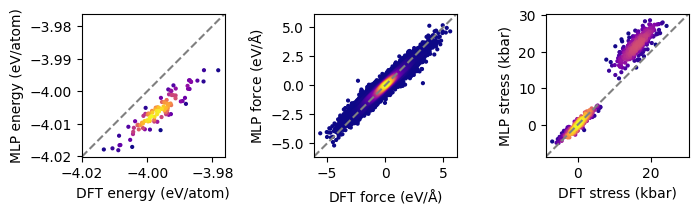

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# draw a parity plot of energy / force / stress
unit = {"energy": "eV/atom", "force": r"eV/$\rm{\AA}$", "stress": "kbar"}
def density_colored_scatter_plot(dft_energy, nnp_energy, dft_force, nnp_force, dft_stress, nnp_stress):
    modes = ['energy', 'force', 'stress']
    plt.figure(figsize=(18/2.54, 6/2.54))
    for num, (x, y) in enumerate(zip([dft_energy, dft_force, dft_stress], [nnp_energy, nnp_force, nnp_stress])):
        mode = modes[num]
        idx = np.random.choice(len(x), 1000) if len(x) > 1000 else list(range(len(x)))
        xsam = [x[i] for i in idx]
        ysam = [y[i] for i in idx]
        xy = np.vstack([x, y])
        xysam = np.vstack([xsam, ysam])
        zsam = gaussian_kde(xysam)

        z = zsam.pdf(xy)
        idx = z.argsort()

        x = [x[i] for i in idx]
        y = [y[i] for i in idx]
        z = [z[i] for i in idx]
        
        ax = plt.subplot(int(f'13{num+1}'))
        plt.scatter(x, y, c=z, s=4, cmap='plasma')

        mini = min(min(x), min(y))
        maxi = max(max(x), max(y))
        ran = (maxi-mini) / 20
        plt.plot([mini-ran, maxi+ran], [mini-ran, maxi+ran], color='grey', linestyle='dashed')
        plt.xlim(mini-ran, maxi+ran)
        plt.ylim(mini-ran, maxi+ran)

        plt.xlabel(f'DFT {mode} ({unit[mode]})')
        plt.ylabel(f'MLP {mode} ({unit[mode]})')
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

density_colored_scatter_plot(dft_energy, mlp_energy, dft_forces, mlp_forces, dft_stress, mlp_stress)

## ASE relaxation & Drawing an EOS curve


In [14]:
import warnings
warnings.filterwarnings("ignore")

from ase.constraints import UnitCellFilter
from ase.optimize import LBFGS
from ase.calculators.singlepoint import SinglePointCalculator

# codes for drawing EOS curve

def atom_oneshot(atoms, calc):
    energy = atoms.get_potential_energy()
    forces = atoms.get_forces()
    stress = atoms.get_stress()

    calc_results = {"energy": energy, "forces": forces, "stress": stress}
    calculator = SinglePointCalculator(atoms, **calc_results)
    atoms = calculator.get_atoms()

    return atoms

def atom_cell_relax(atoms, calc, logfile="-"):
    atoms.calc = calc
    cf = UnitCellFilter(atoms, hydrostatic_strain=True)
    opt = LBFGS(cf, logfile=logfile)
    opt.run(fmax=0.02, steps=1000)

    return atoms

def make_eos_structures(relaxed):
    relaxed_cell = relaxed.get_cell()
    relaxed_lat = relaxed_cell.lengths()[0]
    
    eos_structures = []
    for strain in np.linspace(-0.05, 0.05, 11):
        strained_lat = relaxed_lat * (1+strain)
        relaxed.set_cell([strained_lat]*3, scale_atoms=True)
        eos_structures.append(deepcopy(relaxed))

    return eos_structures

def get_eos_and_volume(eos_list):
    en_list = []
    vol_list = []
    for atoms in eos_list:
        en_list.append(atoms.get_potential_energy())
        vol_list.append(atoms.get_volume())
        
    rel_en_list = np.array(en_list) - min(en_list)

    return rel_en_list, vol_list

In [15]:
# calculate EOS curve
from ase.io import read, write
from sevenn.sevennet_calculator import SevenNetCalculator

os.makedirs('eos', exist_ok=True)
atoms = read('./sevennet_tutorial/data/evaluation/eos.extxyz', ':')[5]
log_path = './eos/seven_relax_log.txt'
relaxed = atom_cell_relax(atoms, sevennet_calc, log_path)

eos_structures = make_eos_structures(relaxed)
eos_oneshot = []
for structure in eos_structures:
    eos_oneshot.append(atom_oneshot(structure, sevennet_calc))

write('./eos/eos.extxyz', eos_oneshot)

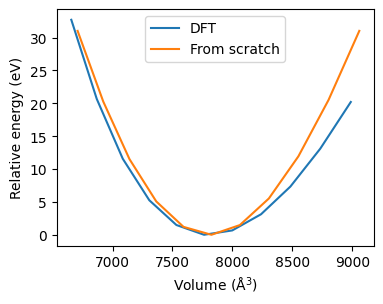

In [16]:
# draw EOS curve and compare with DFT
dft_eos, dft_vol = get_eos_and_volume(read('./sevennet_tutorial/data/evaluation/eos.extxyz', ':'))
mlp_eos, mlp_vol = get_eos_and_volume(read('./eos/eos.extxyz', ':'))

plt.figure(figsize=(10/2.54, 8/2.54))
plt.plot(dft_vol, dft_eos, label='DFT')
plt.plot(mlp_vol, mlp_eos, label='From scratch')

plt.xlabel(r"Volume ($\rm{\AA}^3$)")
plt.ylabel("Relative energy (eV)")

plt.legend()
plt.tight_layout()
plt.show()